In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# --- Spiral Generation and Labeling Functions ---
def generate_spiral(t_max, revolutions, num_points_per_revolution):
    t = np.linspace(0, t_max, revolutions * num_points_per_revolution)
    x = t * np.cos(t)
    y = t * np.sin(t)
    return np.vstack((x, y)).T, t

def classify_points_binary(t):
    """Binary classification: A if t <= 2*pi, B otherwise."""
    return np.where(t <= 2 * np.pi, 'A', 'B')

def classify_points_multiclass(t):
    """Multi-class classification: A, B, C based on t."""
    return np.where(
        t <= 2 * np.pi, 'A',
        np.where(t <= 4 * np.pi, 'B', 'C')
    )

# --- Dataset Creation with Class Imbalance ---
t_max = 6 * np.pi  # Extend t_max to allow for 3 classes
num_points_per_revolution = 100
points, t = generate_spiral(t_max, 3, num_points_per_revolution)

# Binary classification labels
labels_binary = classify_points_binary(t)
label_numerical_binary = np.where(labels_binary == 'A', 0, 1)

# Multi-class classification labels
labels_multiclass = classify_points_multiclass(t)
label_numerical_multiclass = np.where(
    labels_multiclass == 'A', 0,
    np.where(labels_multiclass == 'B', 1, 2)
)

# Introduce class imbalance by keeping only a few samples from one class
def introduce_class_imbalance(X, y, minority_class, minority_count):
    """
    Introduces class imbalance by keeping only `minority_count` samples
    from the specified `minority_class`.
    """
    X_minority = X[y == minority_class][:minority_count]
    y_minority = y[y == minority_class][:minority_count]
    X_majority = X[y != minority_class]
    y_majority = y[y != minority_class]
    return np.vstack((X_majority, X_minority)), np.hstack((y_majority, y_minority))

# Apply class imbalance for binary classification
X_binary_imbalanced, y_binary_imbalanced = introduce_class_imbalance(points, label_numerical_binary, 1, 10)

# Apply class imbalance for multi-class classification
X_multiclass_imbalanced, y_multiclass_imbalanced = introduce_class_imbalance(points, label_numerical_multiclass, 2, 5)

# Split into training and test sets for binary classification
X_train_binary, X_test_binary, y_train_binary, y_test_binary = train_test_split(
    X_binary_imbalanced, y_binary_imbalanced, test_size=0.2, random_state=42
)

# Split into training and test sets for multi-class classification
X_train_multiclass, X_test_multiclass, y_train_multiclass, y_test_multiclass = train_test_split(
    X_multiclass_imbalanced, y_multiclass_imbalanced, test_size=0.2, random_state=42
)

# --- Few-Shot Learning Function (Corrected) ---
def few_shot_learning(X_train, y_train, num_samples_per_class):
    """
    Performs few-shot learning by keeping only `num_samples_per_class`
    samples per class in the training set.
    """
    unique_classes = np.unique(y_train)
    X_few_shot, y_few_shot = [], []
    for cls in unique_classes:
        cls_indices = np.where(y_train == cls)[0]
        # Ensure we don't request more samples than available
        selected_indices = np.random.choice(cls_indices, min(num_samples_per_class, len(cls_indices)), replace=False)
        X_few_shot.append(X_train[selected_indices])
        y_few_shot.append(y_train[selected_indices])
    return np.vstack(X_few_shot), np.hstack(y_few_shot)

# Apply few-shot learning for binary classification
X_train_binary_few_shot, y_train_binary_few_shot = few_shot_learning(X_train_binary, y_train_binary, 5)

# Apply few-shot learning for multi-class classification
X_train_multiclass_few_shot, y_train_multiclass_few_shot = few_shot_learning(X_train_multiclass, y_train_multiclass, 5)

# --- Binary Classification without Few-Shot Learning ---
model_binary = KernelRidge(kernel='rbf')
model_binary.fit(X_train_binary, y_train_binary)

# Predict on test set (binary)
y_pred_kernel_binary = model_binary.predict(X_test_binary)
y_pred_class_kernel_binary = np.round(y_pred_kernel_binary).astype(int)

# Calculate accuracy for binary Kernel Ridge Regression
accuracy_kernel_binary = accuracy_score(y_test_binary, y_pred_class_kernel_binary)

def euclidean_distance_classification(X_train, y_train, X_test):
    predictions = []
    for test_point in X_test:
        distances = np.linalg.norm(X_train - test_point, axis=1)
        nearest_neighbor_idx = np.argmin(distances)
        predictions.append(y_train[nearest_neighbor_idx])
    return np.array(predictions)

y_pred_euclidean_binary = euclidean_distance_classification(X_train_binary, y_train_binary, X_test_binary)
accuracy_euclidean_binary = accuracy_score(y_test_binary, y_pred_euclidean_binary)

model_binary_few_shot = KernelRidge(kernel='rbf')
model_binary_few_shot.fit(X_train_binary_few_shot, y_train_binary_few_shot)

y_pred_kernel_binary_few_shot = model_binary_few_shot.predict(X_test_binary)
y_pred_class_kernel_binary_few_shot = np.round(y_pred_kernel_binary_few_shot).astype(int)

accuracy_kernel_binary_few_shot = accuracy_score(y_test_binary, y_pred_class_kernel_binary_few_shot)

y_pred_euclidean_binary_few_shot = euclidean_distance_classification(X_train_binary_few_shot, y_train_binary_few_shot, X_test_binary)
accuracy_euclidean_binary_few_shot = accuracy_score(y_test_binary, y_pred_euclidean_binary_few_shot)

model_multiclass = KernelRidge(kernel='rbf')
model_multiclass.fit(X_train_multiclass, y_train_multiclass)

y_pred_kernel_multiclass = model_multiclass.predict(X_test_multiclass)
y_pred_class_kernel_multiclass = np.round(y_pred_kernel_multiclass).astype(int)
y_pred_class_kernel_multiclass = np.clip(y_pred_class_kernel_multiclass, 0, 2)

accuracy_kernel_multiclass = accuracy_score(y_test_multiclass, y_pred_class_kernel_multiclass)

y_pred_euclidean_multiclass = euclidean_distance_classification(X_train_multiclass, y_train_multiclass, X_test_multiclass)
accuracy_euclidean_multiclass = accuracy_score(y_test_multiclass, y_pred_euclidean_multiclass)

model_multiclass_few_shot = KernelRidge(kernel='rbf')
model_multiclass_few_shot.fit(X_train_multiclass_few_shot, y_train_multiclass_few_shot)

y_pred_kernel_multiclass_few_shot = model_multiclass_few_shot.predict(X_test_multiclass)
y_pred_class_kernel_multiclass_few_shot = np.round(y_pred_kernel_multiclass_few_shot).astype(int)
y_pred_class_kernel_multiclass_few_shot = np.clip(y_pred_class_kernel_multiclass_few_shot, 0, 2)

accuracy_kernel_multiclass_few_shot = accuracy_score(y_test_multiclass, y_pred_class_kernel_multiclass_few_shot)

y_pred_euclidean_multiclass_few_shot = euclidean_distance_classification(X_train_multiclass_few_shot, y_train_multiclass_few_shot, X_test_multiclass)
accuracy_euclidean_multiclass_few_shot = accuracy_score(y_test_multiclass, y_pred_euclidean_multiclass_few_shot)

print(f"Binary Classification (KernelRidge, No Few-Shot): {accuracy_kernel_binary:.2f}")
print(f"Binary Classification (Euclidean Distance, No Few-Shot): {accuracy_euclidean_binary:.2f}")
print(f"Binary Classification (KernelRidge, Few-Shot): {accuracy_kernel_binary_few_shot:.2f}")
print(f"Binary Classification (Euclidean Distance, Few-Shot): {accuracy_euclidean_binary_few_shot:.2f}")

print(f"Multi-Class Classification (KernelRidge, No Few-Shot): {accuracy_kernel_multiclass:.2f}")
print(f"Multi-Class Classification (Euclidean Distance, No Few-Shot): {accuracy_euclidean_multiclass:.2f}")
print(f"Multi-Class Classification (KernelRidge, Few-Shot): {accuracy_kernel_multiclass_few_shot:.2f}")
print(f"Multi-Class Classification (Euclidean Distance, Few-Shot): {accuracy_euclidean_multiclass_few_shot:.2f}")

Binary Classification (KernelRidge, No Few-Shot): 1.00
Binary Classification (Euclidean Distance, No Few-Shot): 1.00
Binary Classification (KernelRidge, Few-Shot): 1.00
Binary Classification (Euclidean Distance, Few-Shot): 0.95
Multi-Class Classification (KernelRidge, No Few-Shot): 0.83
Multi-Class Classification (Euclidean Distance, No Few-Shot): 0.98
Multi-Class Classification (KernelRidge, Few-Shot): 0.51
Multi-Class Classification (Euclidean Distance, Few-Shot): 0.83


In [ ]:
from sklearn.ensemble import RandomTreesEmbedding
from sklearn.datasets import make_classification
from sklearn.tree import export_text

X, _ = make_classification(n_samples=100, n_features=5, random_state=42)

embedder = RandomTreesEmbedding(n_estimators=10, random_state=42)
embedder.fit(X)

for i, tree in enumerate(embedder.estimators_):
    tree_structure = export_text(tree)
    print(f"Tree {i}:\n{tree_structure}\n")


Tree 0:
|--- feature_2 <= 0.96
|   |--- feature_4 <= -1.03
|   |   |--- feature_2 <= -1.30
|   |   |   |--- feature_1 <= 0.46
|   |   |   |   |--- value: [0.16]
|   |   |   |--- feature_1 >  0.46
|   |   |   |   |--- feature_2 <= -2.04
|   |   |   |   |   |--- value: [0.71]
|   |   |   |   |--- feature_2 >  -2.04
|   |   |   |   |   |--- value: [0.52]
|   |   |--- feature_2 >  -1.30
|   |   |   |--- feature_3 <= 1.36
|   |   |   |   |--- feature_4 <= -1.29
|   |   |   |   |   |--- value: [0.58]
|   |   |   |   |--- feature_4 >  -1.29
|   |   |   |   |   |--- value: [0.76]
|   |   |   |--- feature_3 >  1.36
|   |   |   |   |--- feature_3 <= 1.76
|   |   |   |   |   |--- value: [0.32]
|   |   |   |   |--- feature_3 >  1.76
|   |   |   |   |   |--- value: [0.54]
|   |--- feature_4 >  -1.03
|   |   |--- feature_3 <= 0.19
|   |   |   |--- feature_0 <= -0.37
|   |   |   |   |--- feature_4 <= 0.73
|   |   |   |   |   |--- value: [0.51]
|   |   |   |   |--- feature_4 >  0.73
|   |   |   |   | 

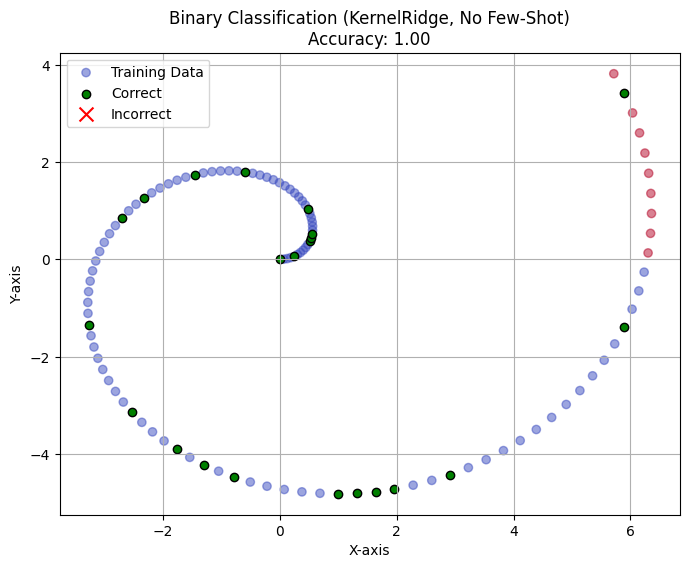

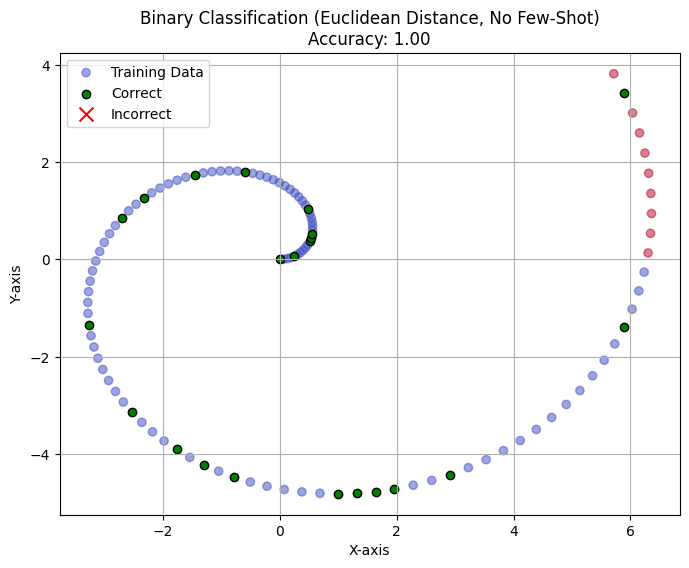

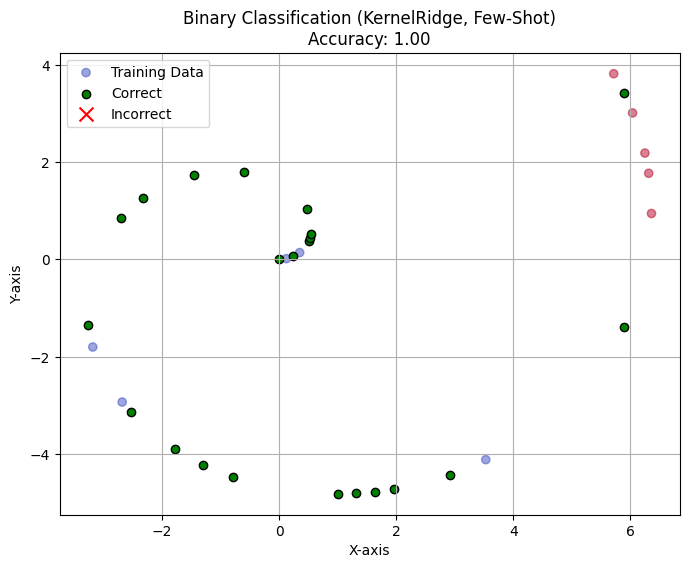

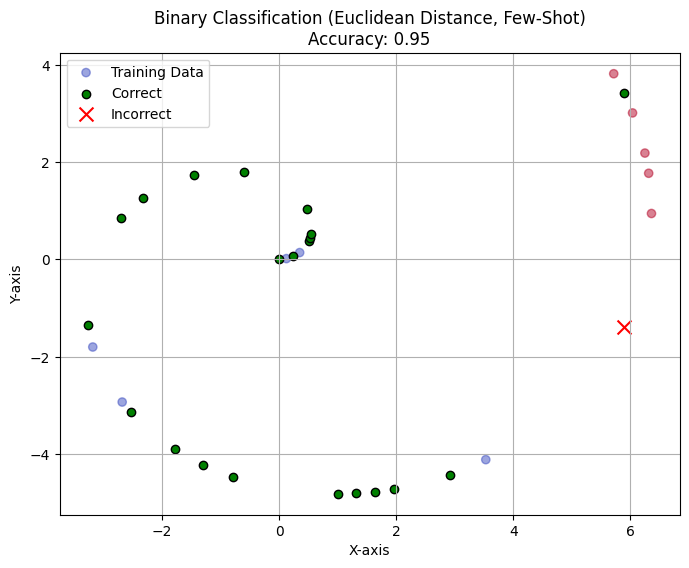

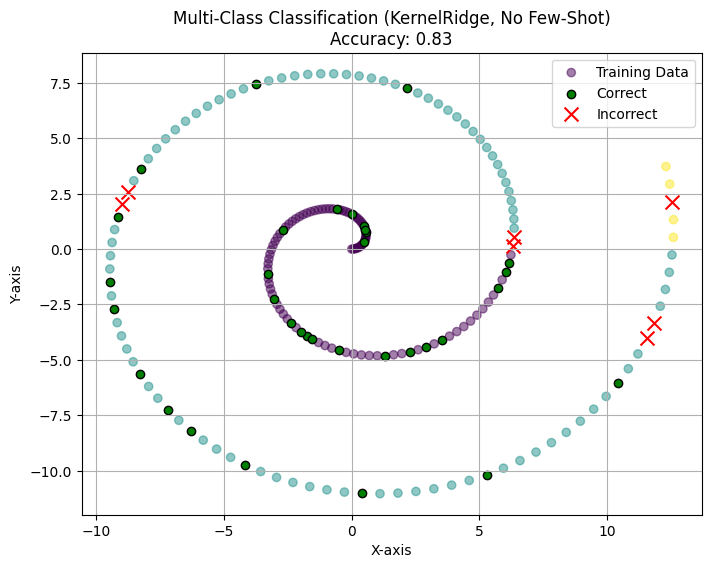

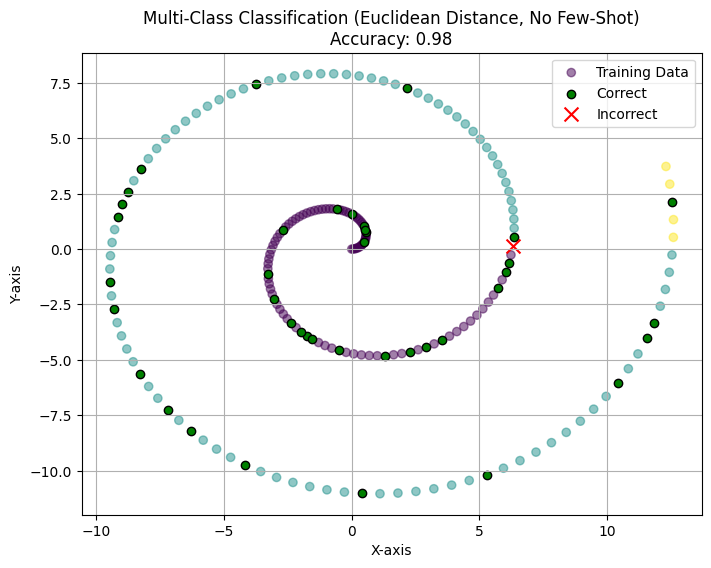

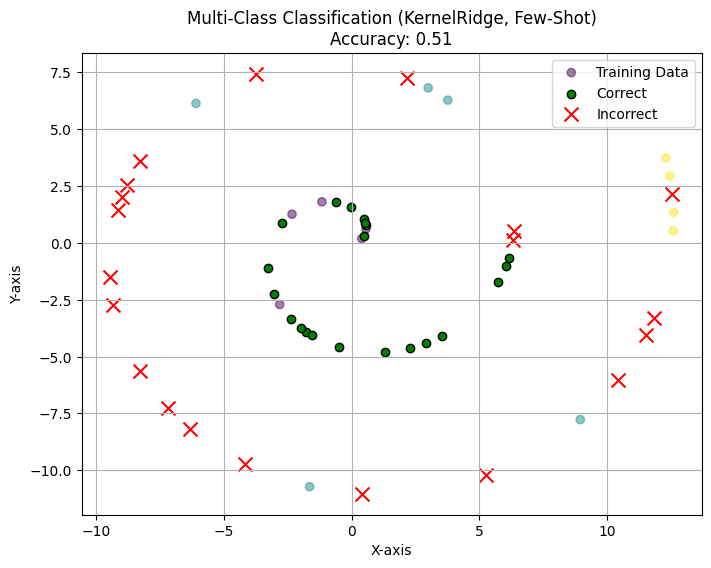

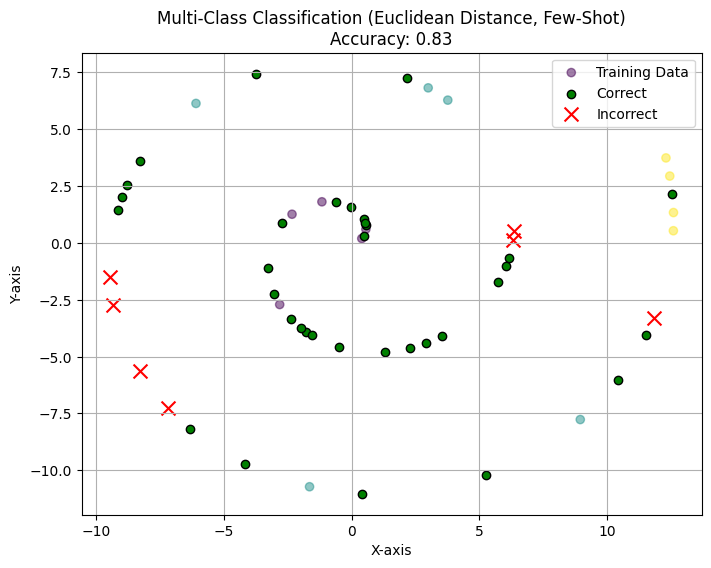

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

def generate_spiral(t_max, revolutions, num_points_per_revolution):
    t = np.linspace(0, t_max, revolutions * num_points_per_revolution)
    x = t * np.cos(t)
    y = t * np.sin(t)
    return np.vstack((x, y)).T, t

def classify_points_binary(t):
    """Binary classification: A if t <= 2*pi, B otherwise."""
    return np.where(t <= 2 * np.pi, 'A', 'B')

def classify_points_multiclass(t):
    """Multi-class classification: A, B, C based on t."""
    return np.where(
        t <= 2 * np.pi, 'A',
        np.where(t <= 4 * np.pi, 'B', 'C')
    )

t_max = 6 * np.pi  # Extend t_max to allow for 3 classes
num_points_per_revolution = 100
points, t = generate_spiral(t_max, 3, num_points_per_revolution)

labels_binary = classify_points_binary(t)
label_numerical_binary = np.where(labels_binary == 'A', 0, 1)

labels_multiclass = classify_points_multiclass(t)
label_numerical_multiclass = np.where(
    labels_multiclass == 'A', 0,
    np.where(labels_multiclass == 'B', 1, 2)
)

def introduce_class_imbalance(X, y, minority_class, minority_count):
    """
    Introduces class imbalance by keeping only `minority_count` samples
    from the specified `minority_class`.
    """
    X_minority = X[y == minority_class][:minority_count]
    y_minority = y[y == minority_class][:minority_count]
    X_majority = X[y != minority_class]
    y_majority = y[y != minority_class]
    return np.vstack((X_majority, X_minority)), np.hstack((y_majority, y_minority))

X_binary_imbalanced, y_binary_imbalanced = introduce_class_imbalance(points, label_numerical_binary, 1, 10)

X_multiclass_imbalanced, y_multiclass_imbalanced = introduce_class_imbalance(points, label_numerical_multiclass, 2, 5)

X_train_binary, X_test_binary, y_train_binary, y_test_binary = train_test_split(
    X_binary_imbalanced, y_binary_imbalanced, test_size=0.2, random_state=42
)

X_train_multiclass, X_test_multiclass, y_train_multiclass, y_test_multiclass = train_test_split(
    X_multiclass_imbalanced, y_multiclass_imbalanced, test_size=0.2, random_state=42
)

def few_shot_learning(X_train, y_train, num_samples_per_class):
    """
    Performs few-shot learning by keeping only `num_samples_per_class`
    samples per class in the training set.
    """
    unique_classes = np.unique(y_train)
    X_few_shot, y_few_shot = [], []
    for cls in unique_classes:
        cls_indices = np.where(y_train == cls)[0]
        selected_indices = np.random.choice(cls_indices, min(num_samples_per_class, len(cls_indices)), replace=False)
        X_few_shot.append(X_train[selected_indices])
        y_few_shot.append(y_train[selected_indices])
    return np.vstack(X_few_shot), np.hstack(y_few_shot)

X_train_binary_few_shot, y_train_binary_few_shot = few_shot_learning(X_train_binary, y_train_binary, 5)

X_train_multiclass_few_shot, y_train_multiclass_few_shot = few_shot_learning(X_train_multiclass, y_train_multiclass, 5)

def visualize_classification(X_train, y_train, X_test, y_test, y_pred, title, cmap='coolwarm'):
    plt.figure(figsize=(8, 6))
    # Plot training data
    plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cmap, alpha=0.5, label='Training Data')
    # Plot test data: correct predictions in green, incorrect in red
    correct = y_test == y_pred
    plt.scatter(X_test[correct, 0], X_test[correct, 1], c='green', marker='o', edgecolors='k', label='Correct')
    plt.scatter(X_test[~correct, 0], X_test[~correct, 1], c='red', marker='x', s=100, label='Incorrect')
    plt.title(title)
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.legend()
    plt.grid()
    plt.show()

model_binary = KernelRidge(kernel='rbf')
model_binary.fit(X_train_binary, y_train_binary)

y_pred_kernel_binary = model_binary.predict(X_test_binary)
y_pred_class_kernel_binary = np.round(y_pred_kernel_binary).astype(int)

accuracy_kernel_binary = accuracy_score(y_test_binary, y_pred_class_kernel_binary)

visualize_classification(
    X_train_binary, y_train_binary, X_test_binary, y_test_binary, y_pred_class_kernel_binary,
    f"Binary Classification (KernelRidge, No Few-Shot)\nAccuracy: {accuracy_kernel_binary:.2f}"
)

def euclidean_distance_classification(X_train, y_train, X_test):

    predictions = []
    for test_point in X_test:
        distances = np.linalg.norm(X_train - test_point, axis=1)
        nearest_neighbor_idx = np.argmin(distances)
        predictions.append(y_train[nearest_neighbor_idx])
    return np.array(predictions)

y_pred_euclidean_binary = euclidean_distance_classification(X_train_binary, y_train_binary, X_test_binary)
accuracy_euclidean_binary = accuracy_score(y_test_binary, y_pred_euclidean_binary)

visualize_classification(
    X_train_binary, y_train_binary, X_test_binary, y_test_binary, y_pred_euclidean_binary,
    f"Binary Classification (Euclidean Distance, No Few-Shot)\nAccuracy: {accuracy_euclidean_binary:.2f}"
)

model_binary_few_shot = KernelRidge(kernel='rbf')
model_binary_few_shot.fit(X_train_binary_few_shot, y_train_binary_few_shot)

y_pred_kernel_binary_few_shot = model_binary_few_shot.predict(X_test_binary)
y_pred_class_kernel_binary_few_shot = np.round(y_pred_kernel_binary_few_shot).astype(int)

accuracy_kernel_binary_few_shot = accuracy_score(y_test_binary, y_pred_class_kernel_binary_few_shot)

visualize_classification(
    X_train_binary_few_shot, y_train_binary_few_shot, X_test_binary, y_test_binary, y_pred_class_kernel_binary_few_shot,
    f"Binary Classification (KernelRidge, Few-Shot)\nAccuracy: {accuracy_kernel_binary_few_shot:.2f}"
)

y_pred_euclidean_binary_few_shot = euclidean_distance_classification(X_train_binary_few_shot, y_train_binary_few_shot, X_test_binary)
accuracy_euclidean_binary_few_shot = accuracy_score(y_test_binary, y_pred_euclidean_binary_few_shot)

visualize_classification(
    X_train_binary_few_shot, y_train_binary_few_shot, X_test_binary, y_test_binary, y_pred_euclidean_binary_few_shot,
    f"Binary Classification (Euclidean Distance, Few-Shot)\nAccuracy: {accuracy_euclidean_binary_few_shot:.2f}"
)

model_multiclass = KernelRidge(kernel='rbf')
model_multiclass.fit(X_train_multiclass, y_train_multiclass)

y_pred_kernel_multiclass = model_multiclass.predict(X_test_multiclass)
y_pred_class_kernel_multiclass = np.round(y_pred_kernel_multiclass).astype(int)
y_pred_class_kernel_multiclass = np.clip(y_pred_class_kernel_multiclass, 0, 2)

accuracy_kernel_multiclass = accuracy_score(y_test_multiclass, y_pred_class_kernel_multiclass)

visualize_classification(
    X_train_multiclass, y_train_multiclass, X_test_multiclass, y_test_multiclass, y_pred_class_kernel_multiclass,
    f"Multi-Class Classification (KernelRidge, No Few-Shot)\nAccuracy: {accuracy_kernel_multiclass:.2f}", cmap='viridis'
)

y_pred_euclidean_multiclass = euclidean_distance_classification(X_train_multiclass, y_train_multiclass, X_test_multiclass)
accuracy_euclidean_multiclass = accuracy_score(y_test_multiclass, y_pred_euclidean_multiclass)

visualize_classification(
    X_train_multiclass, y_train_multiclass, X_test_multiclass, y_test_multiclass, y_pred_euclidean_multiclass,
    f"Multi-Class Classification (Euclidean Distance, No Few-Shot)\nAccuracy: {accuracy_euclidean_multiclass:.2f}", cmap='viridis'
)

model_multiclass_few_shot = KernelRidge(kernel='rbf')
model_multiclass_few_shot.fit(X_train_multiclass_few_shot, y_train_multiclass_few_shot)

y_pred_kernel_multiclass_few_shot = model_multiclass_few_shot.predict(X_test_multiclass)
y_pred_class_kernel_multiclass_few_shot = np.round(y_pred_kernel_multiclass_few_shot).astype(int)
y_pred_class_kernel_multiclass_few_shot = np.clip(y_pred_class_kernel_multiclass_few_shot, 0, 2)

accuracy_kernel_multiclass_few_shot = accuracy_score(y_test_multiclass, y_pred_class_kernel_multiclass_few_shot)

visualize_classification(
    X_train_multiclass_few_shot, y_train_multiclass_few_shot, X_test_multiclass, y_test_multiclass, y_pred_class_kernel_multiclass_few_shot,
    f"Multi-Class Classification (KernelRidge, Few-Shot)\nAccuracy: {accuracy_kernel_multiclass_few_shot:.2f}", cmap='viridis'
)

y_pred_euclidean_multiclass_few_shot = euclidean_distance_classification(X_train_multiclass_few_shot, y_train_multiclass_few_shot, X_test_multiclass)
accuracy_euclidean_multiclass_few_shot = accuracy_score(y_test_multiclass, y_pred_euclidean_multiclass_few_shot)

visualize_classification(
    X_train_multiclass_few_shot, y_train_multiclass_few_shot, X_test_multiclass, y_test_multiclass, y_pred_euclidean_multiclass_few_shot,
    f"Multi-Class Classification (Euclidean Distance, Few-Shot)\nAccuracy: {accuracy_euclidean_multiclass_few_shot:.2f}", cmap='viridis'
)